#  Erdos-Renyi SC Generators Test - Version 1

## Possible approaches

### 1. 
$G(N, p_1, p_2)$ with number of filled triangles (2-simplices) is $p_2 \, \binom{N}{3}$ with downward closure property: if $i, j, k \in SC$ then all pairs in SC.

Approaches:
  - Create a $G(N, p_1)$ skeleton first, then fill in triangles (add any "open" triangle as 2-simplex with prob $p_2$)

  - Independent, filter / project: generate $G(N, p_1, p_2)$ independently, then if $i, j, k$ was picked but not one of its edges: discard it or add mising edges. Here, the actual number of triangles can be too low.


### 2. 
Build clique complexes on E-R random graph

- Create $G(N, p_1)$ graph
- Find cliques (3-cliques only), and fill-in all triangles (add the 2-simplices), downward closure guaranteed by construction. The prob of triangle existing is not independent, but it's prob of all edges of triangle existing ($p_1^3$ for a triangle) summed over all possible triangles. Makes it hard to tune the density..

### 3. 
A random geometric constuction, e.g. Vietoris-Rips based on point placement. Input: disntace threshold eps, and point distribution e.g. uniform on a unit square. Approach: Draw the points in a $[0, 1]^{d}$ then connect them if distance below threshold, it's a clique complex of the graph for triangles. Less pure less combinatorial approach..

In [1]:
import sys
sys.path.append('../src/')
sys.path.append('../scripts/')

from Hypergraphs import EmptyHypergraph

import numpy as np
import matplotlib.pyplot as plt
import os

from scipy.stats import zipf # for power-law Zeta distribution
# from itertools import combinations
from scipy.special import comb

from collections import Counter # for counting degrees

## E-R SC

In [2]:
from generators_sc import *

In [7]:
# test ER SC
N = 1000

k1_k2_list = [(3, 1), (6, 2), (10, 3), (20, 6)]
(k1, k2) = k1_k2_list[3]
print(f"Using (k1, k2) = {(k1, k2)}")

p1, p2 = p1_p2_ER_like_simplicial_complex(k1,k2,N)

print(f"p1 = {p1:.4f}")
print(f"p2 = {p2:.8f}")

giant_order, edges, triangles = ER_like_simplicial_complex(N,p1,p2)
print(f"giant_order = {giant_order}")

Using (k1, k2) = (20, 6)
p1 = 0.0081
p2 = 0.00001204
giant_order = 1000


In [8]:
g_edges = []
all_edges = edges.tolist() + triangles.tolist()
for edge in all_edges:
    g_edges.append(tuple(edge))
print(f"g_edges: {g_edges[:5]}, ..., {g_edges[-5:]}")

g = EmptyHypergraph(N)
g.name = "ER_SC_ver1"
g.set_edges(g_edges)
g.print()

k1_sim = np.mean([len(g.neighbors(i, 1)) for i in list(g.nodes.keys())])
k2_sim = np.mean([len(g.neighbors(i, 2)) for i in list(g.nodes.keys())])
print(f"realized k1:  {k1_sim:.2f}")
print(f"realized k2:  {k2_sim:.2f}\n")

g_edges: [(0, 489), (0, 522), (0, 574), (0, 594), (0, 598)], ..., [(259, 359, 580), (58, 62, 318), (362, 403, 595), (668, 801, 818), (448, 584, 655)]
	ER_SC_ver1 on 1000 nodes with 12119 edges.

realized k1:  20.21
realized k2:  6.04



In [9]:
inter_order_overlap(edges, triangles)

1.0

In [10]:
print(p1, np.log(N) / N)
p1 > np.log(N) / N

0.008105369807497468 0.006907755278982137


np.True_

In [19]:
test_p1_p2 = True
inter_order_overlaps = []
if test_p1_p2:
    max_pw_edges = N * (N - 1) / 2
    max_ho_edges = N * (N - 1) * (N - 2) / 6

    p1_est = []
    p2_est = []
    nsims = 1000
    for _ in range(nsims):
        p1, p2 = p1_p2_ER_like_simplicial_complex(k1,k2,N)
        _, edges, triangles = ER_like_simplicial_complex(N,p1,p2)
        p1_est.append(len(edges) / max_pw_edges)
        p2_est.append(len(triangles) / max_ho_edges)

        inter_order_overlaps.append(inter_order_overlap(edges, triangles))

    print(f"p1_est = {np.mean(p1_est):.4f}")
    print(f"p2_est = {np.mean(p2_est):.8f}")
    # p1_est = 0.0097
    # p2_est = 0.00000568     
    # p1 = 0.0040
    # p2 = 0.00000602
sum(inter_order_overlaps) # == nsims

p1_est = 0.0199
p2_est = 0.00001202


1000.0

In [20]:
test_k1_k2 = True
inter_order_overlaps = []
if test_k1_k2:
    k1_est = []
    k2_est = []
    nsims = 1000
    for _ in range(nsims):
        p1, p2 = p1_p2_ER_like_simplicial_complex(k1,k2,N)
        _, edges, triangles = ER_like_simplicial_complex(N,p1,p2)

        g_type = "random_ER"
        g = EmptyHypergraph(N)
        g.name = g_type
        g.set_edges(g_edges)

        k1_sim = np.mean([len(g.neighbors(i, 1)) for i in list(g.nodes.keys())])
        k2_sim = np.mean([len(g.neighbors(i, 2)) for i in list(g.nodes.keys())])

        k1_est.append(k1_sim)
        k2_est.append(k2_sim)
    
    print(f"k1_est = {np.mean(k1_est):.4f}")
    print(f"k2_est = {np.mean(k2_est):.4f}")
    # Using (k1, k2) = (10, 3)
    # k1_est = 9.6480
    # k2_est = 2.8440

k1_est = 20.0860
k2_est = 6.0720


# Check downward closure property

In this case, presence of triangle implies presence of all pairwise edges of this triangle.

In [21]:
N = 1000
max_pw_edges = comb(N, 2, exact=True) # N * (N - 1) / 2
max_ho_edges = comb(N, 3, exact=True) # N * (N - 1) * (N - 2) / 6

k1_k2_list = [(3, 1), (6, 2), (10, 3), (20, 6)]
(k1, k2) = k1_k2_list[2]

p1, p2 = p1_p2_ER_like_simplicial_complex(k1,k2,N)

print(f"target p1: {p1:.4f}")
print(f"target p2: {p2:.8f}\n")
print(f"target pw edges: {p1 * max_pw_edges:.0f}/{max_pw_edges:.0f}")
print(f"target ho edges: {p2 * max_ho_edges:.0f}/{max_ho_edges:.0f}\n")

target p1: 0.0040
target p2: 0.00000602

target pw edges: 2012/499500
target ho edges: 1000/166167000



In [1]:
_, edges, triangles = ER_like_simplicial_complex(N,p1,p2)

all_edges = edges.tolist() + triangles.tolist()
g_edges = []
for edge in all_edges:
    g_edges.append(tuple(edge))

g = EmptyHypergraph(N)
g.name = "ER_SC_ver1"
g.set_edges(g_edges)
g.print()

NameError: name 'ER_like_simplicial_complex' is not defined

In [23]:
N = 1000
k1, k2 = (10, 3)
p1, p2 = p1_p2_ER_like_simplicial_complex(k1,k2,N)
_, edges, triangles = ER_like_simplicial_complex(N,p1,p2)

print(edges[:5])
print(triangles[:5])

[[  0 216]
 [  0 281]
 [  0 370]
 [  0 399]
 [  0 462]]
[[170 354 408]
 [166 405 766]
 [459 737 764]
 [335 651 699]
 [ 39 301 384]]


In [24]:
def check_downward_closure(edges, triangles):
    edge_set = set()
    for edge in edges:
        edge_set.add(tuple(sorted(edge)))

    is_valid_sc = True
    invalid_triangles = []

    for triangle in triangles:
        tri_sorted = sorted(triangle)
        v1, v2, v3 = tri_sorted[0], tri_sorted[1], tri_sorted[2]

        edge1 = tuple(sorted((v1, v2)))
        edge2 = tuple(sorted((v1, v3)))
        edge3 = tuple(sorted((v2, v3)))

        # check if all 3 edges are present
        if not (edge1 in edge_set and edge2 in edge_set and edge3 in edge_set):
            is_valid_sc = False
            invalid_triangles.append(list(tri_sorted))
            print(f"Invalid triangle {list(tri_sorted)}: ")
            if edge1 not in edge_set: print(f"\t Missing: {edge1}")
            if edge2 not in edge_set: print(f"\t Missing: {edge2}")
            if edge3 not in edge_set: print(f"\t Missing: {edge3}")
    return is_valid_sc

In [25]:
N = 1000
k1, k2 = (10, 3)

nsims = 1000
for _ in range(nsims):
    p1, p2 = p1_p2_ER_like_simplicial_complex(k1,k2,N)
    _, edges, triangles = ER_like_simplicial_complex(N,p1,p2)
    is_valid_sc = check_downward_closure(edges, triangles)
    if not is_valid_sc:
        print("generated invalid SC")

In [14]:
is_valid_sc

True

In [26]:
# try to find connected SC using smaller (k1, k2):
desired_N = 1000
k1_target, k2_target = (10, 3)
p1_sc, p2_sc = p1_p2_ER_like_simplicial_complex(k1_target, k2_target, desired_N)

attempts = 1000
for _ in range(attempts):
    giant_order_realized, edges_realized, triangles_realized = ER_like_simplicial_complex(desired_N, p1_sc, p2_sc)
    if giant_order_realized == desired_N:
        print(f"Found connected SC of size {desired_N}.")
        break

# Degree distribution

In [12]:
# test ER SC
N = 1000

k1_k2_list = [(3, 1), (6, 2), (10, 3), (20, 6)]
(k1, k2) = k1_k2_list[3]
print(f"Using (k1, k2) = {(k1, k2)}")

p1, p2 = p1_p2_ER_like_simplicial_complex(k1,k2,N)

print(f"p1 = {p1:.4f}")
print(f"p2 = {p2:.8f}")

giant_order, edges, triangles = ER_like_simplicial_complex(N,p1,p2)
print(f"giant_order = {giant_order}")

g_edges = []
all_edges = edges.tolist() + triangles.tolist()
for edge in all_edges:
    g_edges.append(tuple(edge))
print(f"g_edges: {g_edges[:5]}, ..., {g_edges[-5:]}")

Using (k1, k2) = (20, 6)
p1 = 0.0081
p2 = 0.00001204
giant_order = 1000
g_edges: [(0, 147), (0, 331), (0, 435), (0, 519), (0, 533)], ..., [(197, 213, 646), (170, 697, 953), (316, 569, 867), (199, 524, 686), (55, 651, 866)]


In [13]:
g = EmptyHypergraph(N)
g.name = "ER_SC"
g.set_edges(g_edges)

k1_sim = np.mean([len(g.neighbors(i, 1)) for i in list(g.nodes.keys())])
k2_sim = np.mean([len(g.neighbors(i, 2)) for i in list(g.nodes.keys())])
print(f"realized k1:  {k1_sim:.2f}")
print(f"realized k2:  {k2_sim:.2f}\n")

realized k1:  20.28
realized k2:  6.21



In [14]:
N_realized = N

degrees_pw_instance = np.zeros(N_realized, dtype=int)
degrees_ho_instance = np.zeros(N_realized, dtype=int)

for i in range(N_realized):
    degrees_pw_instance[i] = len(g.neighbors(i, 1))
    degrees_ho_instance[i] = len(g.neighbors(i, 2))

mean_k1_realized = np.mean(degrees_pw_instance)
mean_k2_realized = np.mean(degrees_ho_instance)

print(f"realized k1:  {mean_k1_realized:.2f}")
print(f"realized k2:  {mean_k2_realized:.2f}\n")

realized k1:  20.28
realized k2:  6.21



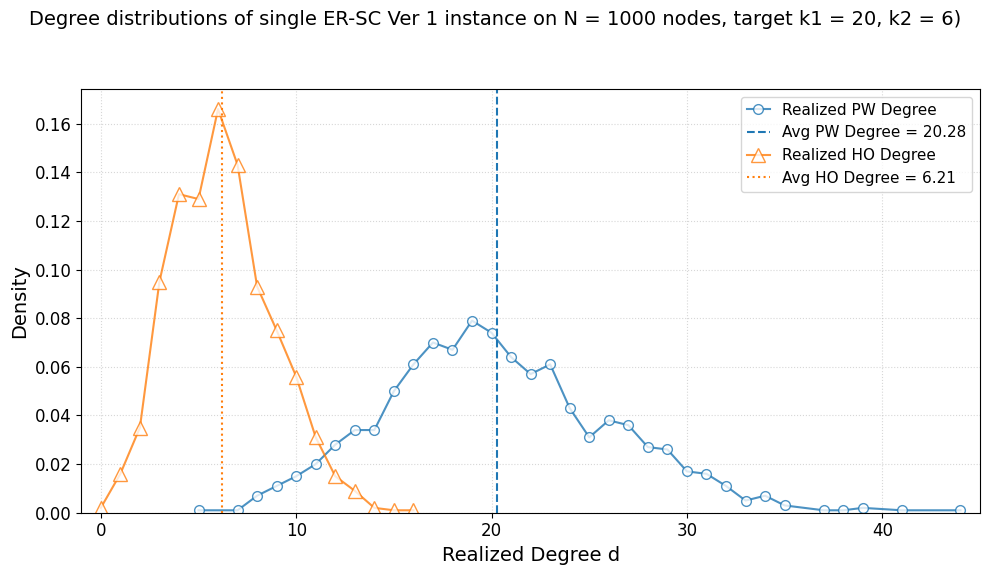

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6)) # on a single figure
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2
plt.rcParams['axes.linewidth'] = 1.2
fig.suptitle(f"Degree distributions of single ER-SC Ver 1 instance on N = {N} nodes, target k1 = {k1}, k2 = {k2})", fontsize=14)

# PW degree distribution
degree_counter_pw = Counter(degrees_pw_instance)
k_vals_pw_plot = sorted(degree_counter_pw.keys())
norm_k1_plot = np.array([degree_counter_pw[k] for k in k_vals_pw_plot]) / float(N_realized)

ax.plot(k_vals_pw_plot, norm_k1_plot, 'o-', label=r'Realized PW Degree',
        clip_on=True, mfc='white', color=u'#1f77b4', markersize=7, alpha=0.8)
ax.axvline(mean_k1_realized, ymax=1,
            linewidth=1.5, linestyle='--', color=u'#1f77b4',
            label=f'Avg PW Degree = {mean_k1_realized:.2f}')

# HO degree distribution
degree_counter_ho = Counter(degrees_ho_instance)
k_vals_ho_plot = sorted(degree_counter_ho.keys())
norm_k2_plot = np.array([degree_counter_ho[k] for k in k_vals_ho_plot]) / float(N_realized)

# ax.plot(k_vals_ho_plot, norm_k2_plot, 'o-', label=r'Realized HO Degree',
#         clip_on=True, mfc='white', color=u'#ff7f0e', markersize=5, alpha=0.8)
ax.plot(k_vals_ho_plot, norm_k2_plot, marker='^', linestyle='-', label=r'Realized HO Degree',
        clip_on=True, mfc='white', color=u'#ff7f0e', markersize=10, alpha=0.8)

ax.axvline(mean_k2_realized, ymax=1,
            linewidth=1.5, linestyle=':', color=u'#ff7f0e',
            label=f'Avg HO Degree = {mean_k2_realized:.2f}')

# plot settings
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Realized Degree d', size=14)
ax.set_ylabel('Density', size=14)
ax.set_ylim(bottom=0)

# Determine appropriate xlim based on both distributions
max_deg_overall = 0
if len(degrees_pw_instance) > 0:
    max_deg_overall = max(max_deg_overall, np.max(degrees_pw_instance))
if len(degrees_ho_instance) > 0:
    max_deg_overall = max(max_deg_overall, np.max(degrees_ho_instance))
ax.set_xlim(left=-1, right=max_deg_overall + 1 if max_deg_overall > 0 else 10)

ax.legend(fontsize=11, loc='upper right', handlelength=1.5, frameon=True) # frameon might look better
ax.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])

plt.savefig(f"../figures/hypergraphs/degree_distributions_ER_SC_ver1.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()